# Importing Libraries for Hand Gesture Recognition and ML Model Training

In [1]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib

# MediaPipe and OpenCV for hand tracking and real-time video
import mediapipe as mp
import cv2

# For smoothing predictions
from collections import deque

from sklearn.decomposition import PCA

In [2]:
#load the dataset
df  = pd.read_csv("dataset/hand_landmarks_data.csv")
df 

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,259.135620,277.542236,4.323656e-07,271.098221,257.333374,0.007132,269.350250,237.538345,0.004480,257.334503,...,231.102150,230.308350,-0.028861,235.017242,235.029312,-0.016911,237.608711,240.918411,-0.006697,two_up_inverted
25671,90.063995,256.181732,3.808555e-07,77.302231,237.829132,0.003778,78.658888,220.471680,-0.001519,89.374163,...,116.692326,210.932007,-0.043690,112.681984,215.274353,-0.029510,110.178349,221.338379,-0.015630,two_up_inverted
25672,236.724518,251.496756,5.912488e-07,254.918358,232.369956,0.001354,256.002502,209.969106,-0.001674,247.075447,...,211.933777,202.389975,-0.031740,215.493393,208.953272,-0.021970,218.057648,215.236920,-0.010803,two_up_inverted
25673,119.466957,309.842529,4.319564e-07,111.772064,291.310333,0.006174,116.895447,273.683929,0.001893,129.239788,...,157.217422,271.056702,-0.046297,154.780106,277.261139,-0.032800,150.117119,282.011047,-0.020277,two_up_inverted


# Check if normalization is needed

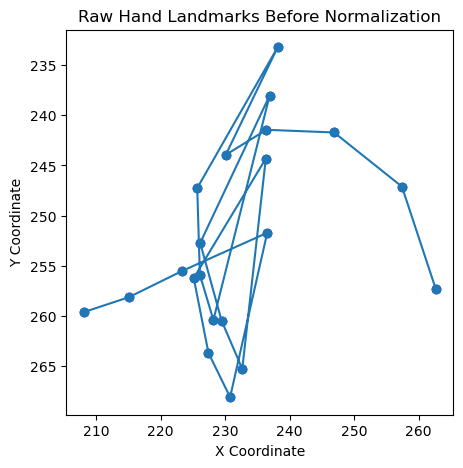

In [3]:
# Select a single sample (randomly or first row)
sample = df.iloc[0, :-1].values  # Exclude label column

# Extract x and y coordinates
x_coords = sample[0::3]  # extract all Xs
y_coords = sample[1::3]  # extract all Ys

# Plot hand landmarks
plt.figure(figsize=(5, 5))
plt.scatter(x_coords, y_coords, color="blue")
plt.plot(x_coords, y_coords, linestyle='-', marker='o')  # Connect keypoints

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Raw Hand Landmarks Before Normalization")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
plt.show()

The landmarks are spread across a wide range of X and Y coordinates instead of being aligned around a reference point (such as the wrist).
Normalization Will Fix the issues, also scaling is needed as there may be different hand sizes

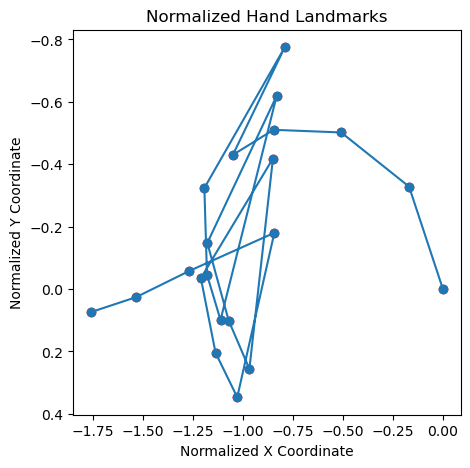

In [4]:
def normalize_landmarks(sample):
    # Extract x and y coordinates
    x_coords = np.array(sample[0::3])
    y_coords = np.array(sample[1::3])

    # Use wrist (landmark 0) as reference point
    wrist_x, wrist_y = x_coords[0], y_coords[0]

    # Recenter the hand
    x_coords -= wrist_x
    y_coords -= wrist_y

    # Scale using the mid-finger tip (landmark 12 or 8)
    scale_factor = np.linalg.norm([x_coords[12], y_coords[12]])  # Distance to mid-finger tip

    # Avoid division by zero
    if scale_factor > 0:
        x_coords /= scale_factor
        y_coords /= scale_factor

    return x_coords, y_coords

# Normalize and visualize
x_norm, y_norm = normalize_landmarks(sample)

plt.figure(figsize=(5, 5))
plt.scatter(x_norm, y_norm, color="red")
plt.plot(x_norm, y_norm, linestyle='-', marker='o')

plt.xlabel("Normalized X Coordinate")
plt.ylabel("Normalized Y Coordinate")
plt.title("Normalized Hand Landmarks")
plt.gca().invert_yaxis()
plt.show()

# Data Cleaning and preprocessing 

For a gesture recognition model using normal cameras, we just need (X, Y) so drop Z.

In [ ]:
# Drop all columns with 'z' in their names
#df_2D = df.drop(columns=[col for col in df.columns if 'z' in col])

In [3]:
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

In [4]:
# Find rows with more than one null value
rows_with_nulls = df[df.isnull().sum(axis=1) > 1]

rows_with_nulls

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [6]:
#convert label column into string type
df["label"] = df["label"].astype("string")

In [7]:
df.dtypes

x1              float64
y1              float64
z1              float64
x2              float64
y2              float64
              ...      
z20             float64
x21             float64
y21             float64
z21             float64
label    string[python]
Length: 64, dtype: object

In [8]:
#make sure label column only has 18 classes
df["label"].nunique()

18

In [9]:
df["label"].value_counts()

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: Int64

In [10]:
# Define the gesture renaming map
gesture_map = {
    'three2': 'up',
    'four': 'up',
    'palm': 'up',
    'like': 'up',
    'two_up': 'up',
    'two_up_inverted': 'up',
    'ok': 'up',

    'dislike': 'down',
    'one': 'down',
    'mute': 'down',

    'fist': 'left',
    'peace': 'left',
    'peace_inverted': 'left',
    'rock': 'left',

    'call': 'right',
    'stop': 'right',
    'stop_inverted': 'right',
    'three': 'right',
}

df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: gesture_map.get(x, x))

# Apply the renaming directly on df_2D
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: gesture_map.get(x, x))  # Rename only those 4




In [11]:
# Separate data by class
up_df = df[df.iloc[:, -1] == 'up']
down_df = df[df.iloc[:, -1] == 'down']
left_df = df[df.iloc[:, -1] == 'left']
right_df = df[df.iloc[:, -1] == 'right']

# Downsample 'up' to 6000 samples (or any target number)
up_downsampled = up_df.sample(n=6000, random_state=42)
# Combine all back
balanced_df = pd.concat([up_downsampled, down_df, left_df, right_df])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
df = balanced_df.copy()

In [13]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])  # Convert gesture names to integers

# Save the mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'down': 0, 'left': 1, 'right': 2, 'up': 3}


C:\Users\ayman\AppData\Local\Temp\ipykernel_7696\2771665547.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 1 ... 3 3 2]' has dtype incompatible with string, please explicitly cast to a compatible dtype first.
  df.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])  # Convert gesture names to integers


In [14]:
df["label"].value_counts()

label
2    6011
3    6000
1    5341
0    3645
Name: count, dtype: int64

In [15]:
print("Unique labels after renaming and encoding:", label_encoder.classes_)


Unique labels after renaming and encoding: ['down' 'left' 'right' 'up']


In [15]:
df["label"]

0        3
1        2
2        1
3        2
4        3
        ..
20992    1
20993    1
20994    3
20995    3
20996    2
Name: label, Length: 20997, dtype: int32

### Normalization and scaling

In [25]:
# Select x, y, and z coordinate columns (landmarks 1 to 21)
x_coords = [f"x{i}" for i in range(1, 22)]
y_coords = [f"y{i}" for i in range(1, 22)]
z_coords = [f"z{i}" for i in range(1, 22)]

# Extract x, y, z values
x_vals = df[x_coords].copy()
y_vals = df[y_coords].copy()
z_vals = df[z_coords].copy()

# Wrist coordinates = landmark 1
wrist_x = x_vals["x1"]
wrist_y = y_vals["y1"]
wrist_z = z_vals["z1"]

# Recenter all coordinates using wrist
x_vals = x_vals.subtract(wrist_x, axis=0)
y_vals = y_vals.subtract(wrist_y, axis=0)
z_vals = z_vals.subtract(wrist_z, axis=0)

# Normalize using 3D distance from wrist to fingertip (landmark 14)
dist = np.sqrt(
    x_vals["x14"]**2 + 
    y_vals["y14"]**2 + 
    z_vals["z14"]**2
)

# Avoid division by zero
dist.replace(0, 1e-6, inplace=True)

# Normalize coordinates by this distance
for i in range(len(dist)):
    x_vals.iloc[i] /= dist[i]
    y_vals.iloc[i] /= dist[i]
    z_vals.iloc[i] /= dist[i]

# Interleave x, y, z as x1, y1, z1, x2, y2, z2, ..., x21, y21, z21
normalized_data = []
for i in range(1, 22):
    normalized_data.append(x_vals[f"x{i}"])
    normalized_data.append(y_vals[f"y{i}"])
    normalized_data.append(z_vals[f"z{i}"])

# Combine all columns into a single DataFrame
normalized_df = pd.concat(normalized_data, axis=1)

# Rename columns accordingly
new_cols = []
for i in range(1, 22):
    new_cols.extend([f"x{i}", f"y{i}", f"z{i}"])
normalized_df.columns = new_cols

# Add label back
normalized_df["label"] = df["label"]


In [26]:
normalized_df

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,0.0,0.0,0.0,-0.288283,-0.226493,-0.000216,-0.496660,-0.499959,-0.000451,-0.643729,...,0.682086,-1.032414,-0.000951,0.777089,-1.228664,-0.000990,0.816152,-1.416438,-0.000998,3
1,0.0,0.0,0.0,-0.010680,-0.536403,-0.000112,0.124077,-1.195673,-0.000316,0.146251,...,1.475303,-0.368411,-0.000978,1.791972,-0.429877,-0.000938,2.054950,-0.515783,-0.000914,2
2,0.0,0.0,0.0,0.332693,-0.118028,-0.000440,0.621871,-0.410055,-0.000661,0.622577,...,-0.164697,-1.366240,-0.001171,-0.190784,-1.627970,-0.001211,-0.190238,-1.877252,-0.001113,1
3,0.0,0.0,0.0,-0.149521,-0.102507,-0.000684,-0.149876,-0.315677,-0.000983,0.119725,...,0.452633,-0.915869,-0.001060,0.397325,-0.752290,-0.001132,0.351003,-0.558536,-0.001157,2
4,0.0,0.0,0.0,0.256929,-0.127058,-0.000154,0.481622,-0.338305,-0.000294,0.697293,...,-0.218583,-1.272093,-0.000553,-0.239561,-1.504051,-0.000533,-0.250518,-1.691622,-0.000502,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20992,0.0,0.0,0.0,0.262977,-0.292869,-0.000491,0.274680,-0.692186,-0.000661,-0.019865,...,-0.506756,-1.000059,-0.000895,-0.379371,-0.860620,-0.000873,-0.291223,-0.693097,-0.000708,1
20993,0.0,0.0,0.0,-0.321817,-0.225129,-0.000283,-0.442659,-0.554606,-0.000471,-0.216971,...,0.445997,-1.046260,-0.000804,0.389199,-0.941457,-0.000720,0.343640,-0.793140,-0.000574,1
20994,0.0,0.0,0.0,-0.272933,-0.207325,-0.000295,-0.384221,-0.595849,-0.000426,-0.151163,...,0.622184,-1.093146,-0.000863,0.730535,-1.301961,-0.001032,0.814093,-1.488951,-0.001154,3
20995,0.0,0.0,0.0,0.400848,-0.051900,-0.000555,0.786868,-0.249699,-0.000830,1.103940,...,-0.249095,-1.195400,-0.000921,-0.289872,-1.412693,-0.001085,-0.315080,-1.605077,-0.001170,3


# visualization

label
2    6011
3    6000
1    5341
0    3645
Name: count, dtype: int64


C:\Users\ayman\AppData\Local\Temp\ipykernel_7696\3120622390.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


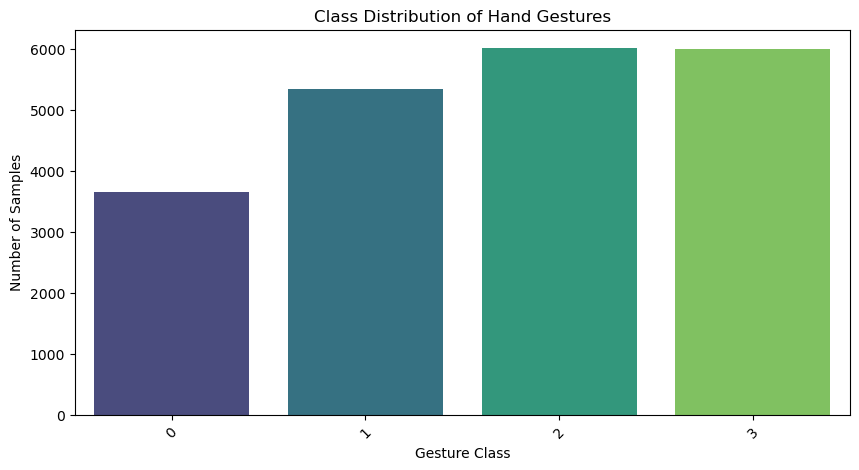

In [27]:
# Check Class Distribution
class_counts = normalized_df['label'].value_counts()
print(class_counts)

# Plot Class Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Gesture Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Hand Gestures")
plt.xticks(rotation=45)
plt.show()

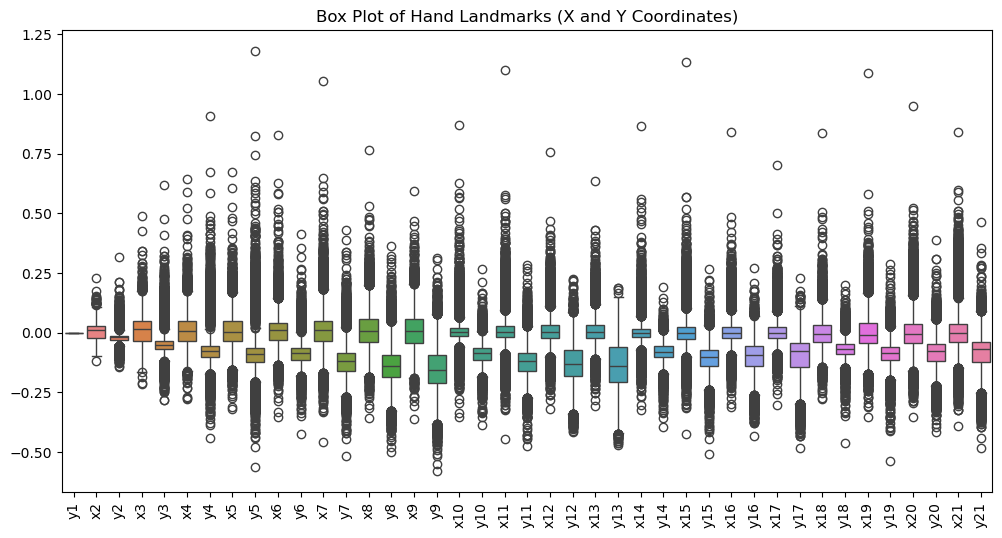

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_df.iloc[:, 1:-1])  # Skip first and last columns
plt.xticks(rotation=90)
plt.title("Box Plot of Hand Landmarks (X and Y Coordinates)")
plt.show()

Box Plot of Hand Landmarks (X and Y Coordinates). Outlier removal is unnecessary as the outliers are relatively sparse and may represent meaningful hand variations rather than noise.

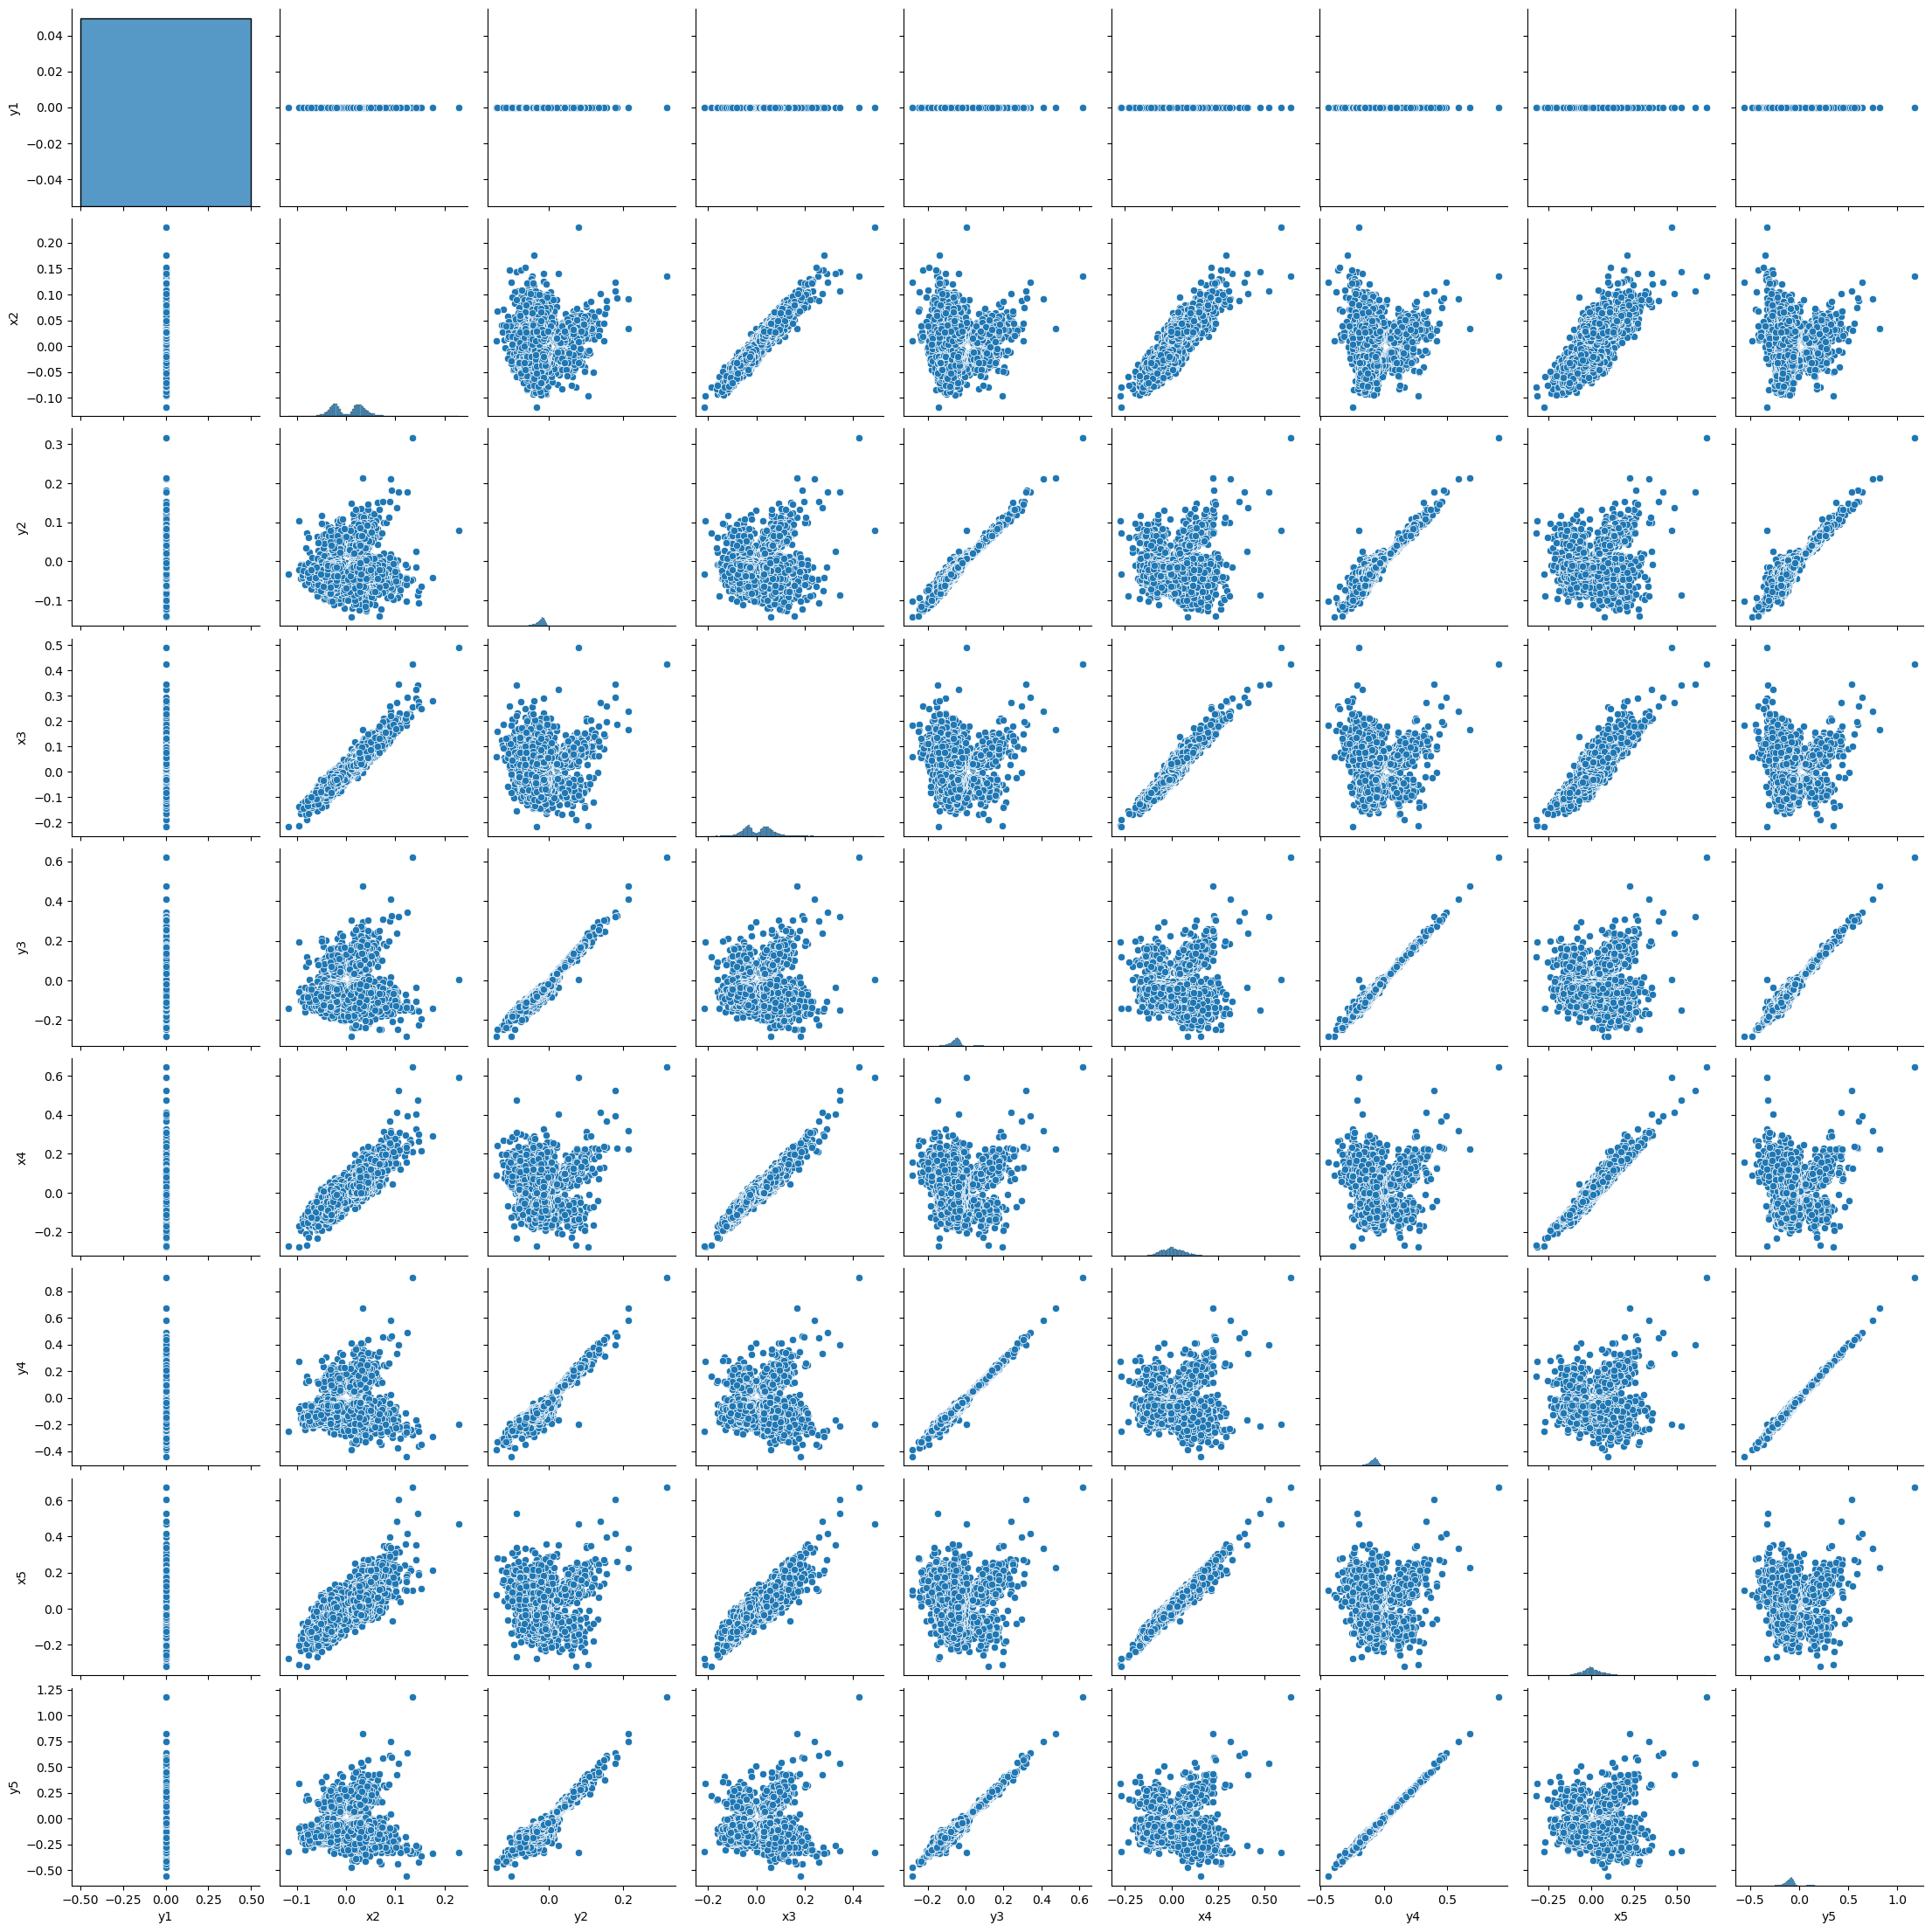

In [21]:
sns.pairplot(normalized_df.iloc[:, 1:10])  # Select a few columns to avoid clutter
plt.show()

       y1        x2        y2        x3        y3        x4        y4  \
y1    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
x2    NaN  1.000000 -0.010351  0.968800 -0.054194  0.862102 -0.077326   
y2    NaN -0.010351  1.000000 -0.022632  0.972493 -0.027500  0.935596   
x3    NaN  0.968800 -0.022632  1.000000 -0.060580  0.951786 -0.081288   
y3    NaN -0.054194  0.972493 -0.060580  1.000000 -0.052928  0.988847   
x4    NaN  0.862102 -0.027500  0.951786 -0.052928  1.000000 -0.067499   
y4    NaN -0.077326  0.935596 -0.081288  0.988847 -0.067499  1.000000   
x5    NaN  0.724581 -0.020986  0.842656 -0.034400  0.963127 -0.042315   
y5    NaN -0.085721  0.913882 -0.088588  0.971843 -0.073311  0.993452   
x6    NaN  0.748703  0.000810  0.840430 -0.021569  0.815451 -0.035923   
y6    NaN -0.168815  0.703795 -0.169126  0.818757 -0.147505  0.844899   
x7    NaN  0.721660 -0.036381  0.826114 -0.057365  0.816384 -0.070048   
y7    NaN -0.141674  0.574081 -0.130538  0.705427 -

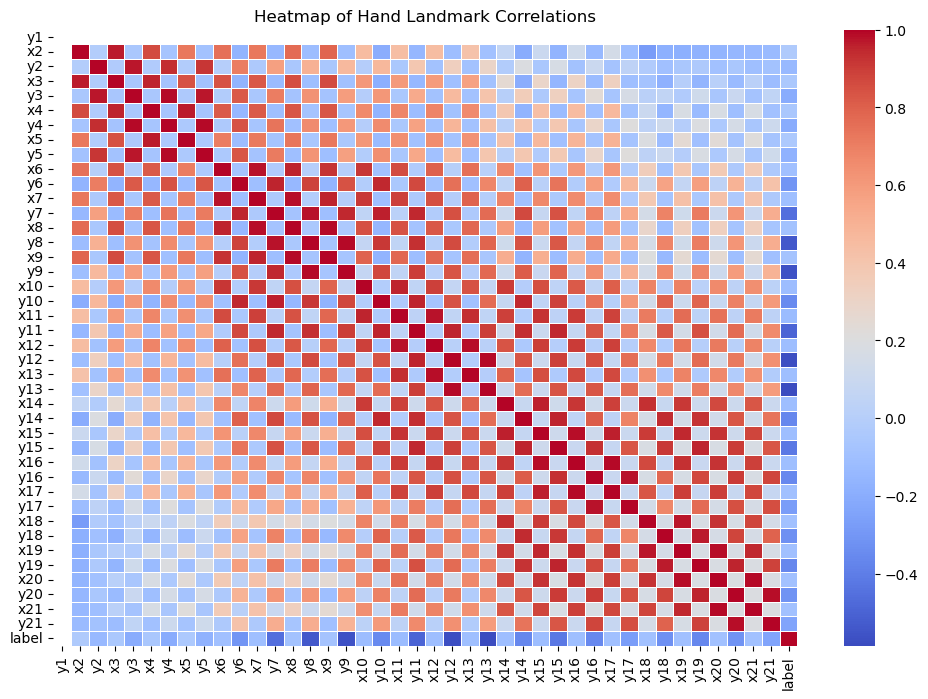

In [43]:
# Compute correlation matrix (excluding first column if needed)
corr_matrix = normalized_df.iloc[:, 1:].corr()  

# Display correlation values
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Hand Landmark Correlations")
plt.show()


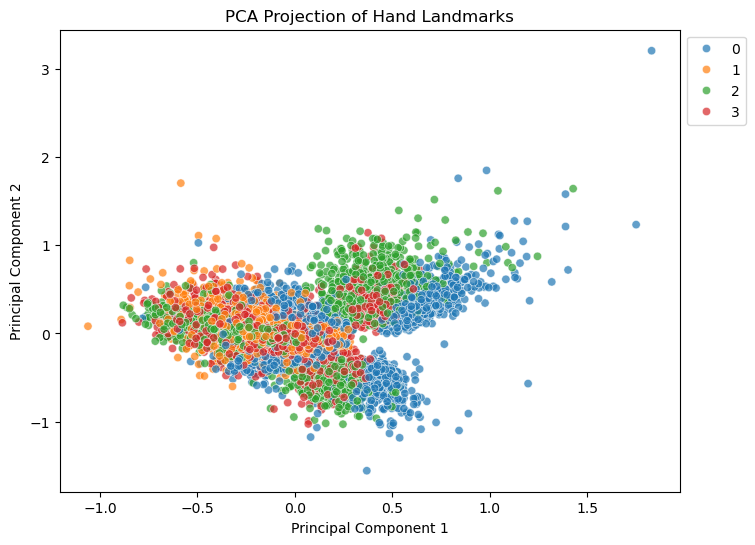

In [22]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df.iloc[:, :-1])  # Exclude label column

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=normalized_df['label'], palette="tab10", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Hand Landmarks")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


Given overlapping gestures, a more sophisticated classifier (e.g., deep learning or ensemble methods) may be required to improve accuracy.

# Model implementation 

In [29]:
# Separate features (X) and label (y)
X = normalized_df.drop(columns=["label"])  # Features
y = normalized_df["label"]  # Target


In [30]:
# Split the dataset into training,val,test
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Initialize individual models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Initialize the ensemble model (Voting Classifier)
ensemble_model = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('xgb', models['XGBoost']),
    ('lr', models['Logistic Regression']),
    ('dt', models['Decision Tree'])
], voting='hard')  # 'hard' voting for classification (majority rule)

# Add ensemble to models dictionary for easier handling
models['Ensemble'] = ensemble_model

# Set up K-Fold Cross Validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Perform Cross-Validation for each model
for name, model in models.items():
    print(f"Training and evaluating {name}...")

    # Cross-validation score (accuracy)
    scores = cross_val_score(model, X_train_temp, y_train_temp, cv=kf, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    std_dev = np.std(scores)

    # Store the results
    results[name] = {
        'mean_accuracy': mean_accuracy,
        'std_dev': std_dev
    }

    # Train the model on the full training data
    model.fit(X_train_temp, y_train_temp)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train_temp)
    
    # Compute evaluation metrics for training data
    accuracy = accuracy_score(y_train_temp, y_pred_train)
    precision = precision_score(y_train_temp, y_pred_train, average='macro')
    recall = recall_score(y_train_temp, y_pred_train, average='macro')
    f1 = f1_score(y_train_temp, y_pred_train, average='macro')

    # Add metrics to results
    results[name].update({
        'train_accuracy': accuracy,
        'train_precision': precision,
        'train_recall': recall,
        'train_f1': f1
    })

    print(f"{name} (Train) - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
# Evaluate models on the validation set
for name, model in models.items():
    y_pred_val = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')
    val_f1 = f1_score(y_val, y_pred_val, average='macro')
    
    results[name].update({
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })
    
    print(f"{name} Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")

# Final evaluation on the test set
for name, model in models.items():
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='macro')
    test_recall = recall_score(y_test, y_pred_test, average='macro')
    test_f1 = f1_score(y_test, y_pred_test, average='macro')
    
    results[name].update({
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    })
    
    print(f"{name} Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

# Conclusion: Summarizing the best model
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_model_results = results[best_model_name]

print("\nSummary of Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Training Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['test_precision']:.4f}")
    print(f"  Recall: {metrics['test_recall']:.4f}")
    print(f"  F1-score: {metrics['test_f1']:.4f}")

print(f"\nBest Performing Model: {best_model_name}")
print(f"Test Accuracy: {best_model_results['test_accuracy']:.4f}")
print(f"Test Precision: {best_model_results['test_precision']:.4f}")
print(f"Test Recall: {best_model_results['test_recall']:.4f}")
print(f"Test F1-score: {best_model_results['test_f1']:.4f}")


Training and evaluating Random Forest...
Random Forest (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating SVM...
SVM (Train) - Accuracy: 0.8719, Precision: 0.8818, Recall: 0.8838, F1-score: 0.8807
Training and evaluating XGBoost...


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

XGBoost (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating Logistic Regression...
Logistic Regression (Train) - Accuracy: 0.8446, Precision: 0.8552, Recall: 0.8582, F1-score: 0.8554
Training and evaluating Decision Tree...
Decision Tree (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating Ensemble...


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Ensemble (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Random Forest Validation - Accuracy: 0.9771, Precision: 0.9784, Recall: 0.9778, F1-score: 0.9780
SVM Validation - Accuracy: 0.8648, Precision: 0.8746, Recall: 0.8796, F1-score: 0.8748
XGBoost Validation - Accuracy: 0.9890, Precision: 0.9897, Recall: 0.9889, F1-score: 0.9893
Logistic Regression Validation - Accuracy: 0.8400, Precision: 0.8508, Recall: 0.8552, F1-score: 0.8522
Decision Tree Validation - Accuracy: 0.9686, Precision: 0.9701, Recall: 0.9689, F1-score: 0.9694
Ensemble Validation - Accuracy: 0.9800, Precision: 0.9811, Recall: 0.9813, F1-score: 0.9811
Random Forest Test - Accuracy: 0.9805, Precision: 0.9819, Recall: 0.9812, F1-score: 0.9814
SVM Test - Accuracy: 0.8700, Precision: 0.8792, Recall: 0.8820, F1-score: 0.8787
XGBoost Test - Accuracy: 0.9852, Precision: 0.9864, Recall: 0.9863, F1-score: 0.9863
Logistic Regression Test - Accuracy: 0.8471, Precision: 0.8577, Recall: 0.8594, F1-scor

the output shows that the model might be overfitting so optimizations are required

2. hyperparameter tuning

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Split the dataset into training, validation, and test sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the XGBoost model with regularization
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

# Define hyperparameter grid for tuning (with additional values to prevent overfitting)
param_grid = {
    'colsample_bytree': [0.7],
    'gamma': [1],
    'learning_rate': [0.05],
    'max_depth': [4],
    'min_child_weight': [5],
    'n_estimators': [200],
    'subsample': [0.8],
    'reg_alpha': [0.2],
    'reg_lambda': [0.8]     
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train_temp, y_train_temp)

# Print all results per run
print("\n=== Grid Search Results ===")
for mean_score, params in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]):
    print(f"Params: {params}, Mean Accuracy: {mean_score:.4f}")

# Get the best hyperparameters
print(f"\nBest Parameters: {grid_search.best_params_}")

# Train the best model from grid search
best_model = grid_search.best_estimator_

# Function to calculate precision and F1 for multiclass (weighted average)
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for multiclass
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted average for multiclass
    return accuracy, precision, f1

# Evaluate on training set
train_pred = best_model.predict(X_train_temp)
train_accuracy, train_precision, train_f1 = calculate_metrics(y_train_temp, train_pred)

print("\nTraining Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, F1-Score: {train_f1:.4f}")

# Evaluate on validation set
val_pred = best_model.predict(X_val)
val_accuracy, val_precision, val_f1 = calculate_metrics(y_val, val_pred)

print("\nValidation Set Evaluation:")
print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, F1-Score: {val_f1:.4f}")

# Final evaluation on test set
test_pred = best_model.predict(X_test)
test_accuracy, test_precision, test_f1 = calculate_metrics(y_test, test_pred)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, F1-Score: {test_f1:.4f}")

# K-Fold Cross-Validation (with the best model)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_temp, y_train_temp, cv=kf, scoring='accuracy')

print(f"\nXGBoost K-Fold Cross-Validation Mean Accuracy: {np.mean(cv_scores):.4f}, Std Dev = {np.std(cv_scores):.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== Grid Search Results ===
Params: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.8, 'subsample': 0.8}, Mean Accuracy: 0.9798

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.8, 'subsample': 0.8}

Training Set Evaluation:
Accuracy: 0.9890, Precision: 0.9891, F1-Score: 0.9891

Validation Set Evaluation:
Accuracy: 0.9829, Precision: 0.9829, F1-Score: 0.9829

Test Set Evaluation:
Accuracy: 0.9790, Precision: 0.9791, F1-Score: 0.9790

XGBoost K-Fold Cross-Validation Mean Accuracy: 0.9811, Std Dev = 0.0010


In [36]:
# Save the best model to a file
model_filename = 'best_xgboost.joblib'
joblib.dump(best_model, model_filename)
print(f"\nModel saved to {model_filename}")


Model saved to best_xgboost.joblib


In [37]:
loaded_model = joblib.load('best_xgboost.joblib')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)

print(f"Final Test Accuracy of the Loaded Model: {final_accuracy:.4f}")


Final Test Accuracy of the Loaded Model: 0.9790
